In [1]:
import sys
sys.path.append('old/')
from fastai.text import *

## select only part of the data for training

In [2]:
with open('../out/aviation/tokens_post.txt', 'rb') as fp:
    tokens_post = pickle.load(fp)

In [3]:
df_post = pd.read_csv('../out/aviation/df_post.csv', parse_dates=['post_date'])

In [4]:
len(tokens_post),len(df_post)

(54844, 54844)

In [5]:
np.sum(df_post.post_date >= datetime.date(2018,7,1))

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


2135

In [8]:
idx_chosen = df_post[df_post.post_date >= datetime.date(2018,7,1)].index
tkn_sel = [tkn for idx in idx_chosen for tkn in tokens_post[idx]]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


## set directories

In [23]:
LM_PATH = Path('lm')
LM_PATH.mkdir(exist_ok=True)

In [16]:
!ls ../out/aviation

df_post.csv  tokens_post.txt


In [24]:
DATA_PATH = LM_PATH.joinpath('data')
DATA_PATH.mkdir(exist_ok=True)

In [22]:
with open(f'{DATA_PATH}/tkn_sel.pkl','wb') as fp:
    pickle.dump(tkn_sel,fp)

In [26]:
TMP_PATH = LM_PATH.joinpath('tmp')
TMP_PATH.mkdir(exist_ok=True)

In [19]:
# check original path for pretrained model
!ls ../../pretrained_wiki

thwiki_itos.pkl  thwiki_lm.pth


In [27]:
PRETRAINED_PATH = LM_PATH.joinpath('pretrained')
PRETRAINED_PATH.mkdir(exist_ok=True)
# !cp ../../pretrained_wiki/thwiki_itos.pkl ../../pretrained_wiki/thwiki_lm.pth {PRETRAINED_PATH}

In [28]:
MODEL_PATH = LM_PATH.joinpath('model')
MODEL_PATH.mkdir(exist_ok=True)

## Import tokens for training

In [29]:
# read the token
with open(f'{DATA_PATH}/tkn_sel.pkl','rb') as fp:
    tok_data = pickle.load(fp)

len(tok_data)

246779

In [30]:
# split data for train & test
tok_trn = tok_data[:int(0.9*len(tok_data))]
tok_val = tok_data[int(0.9*len(tok_data)):]

In [31]:
len(tok_trn), len(tok_val)

(222101, 24678)

In [32]:
freq = Counter(t for t in tok_trn)
freq.most_common(25)

[(' ', 69641),
 ('number', 3542),
 ('บิน', 2112),
 ('สายการบิน', 1765),
 ('เครื่อง', 1585),
 ('ผม', 1498),
 ('ไหม', 1085),
 ('ไทย', 1062),
 ('เดินทาง', 1004),
 ('ตั๋ว', 980),
 ('เครื่องบิน', 956),
 ('จอง', 915),
 ('คน', 868),
 ('time', 848),
 ('ซื้อ', 819),
 ('เวลา', 810),
 ('กระเป๋า', 808),
 ('ไม่ได้', 768),
 ('สนามบิน', 707),
 ('ทำ', 689),
 ('ดี', 689),
 ('ที่นั่ง', 654),
 ('ราคา', 643),
 ('แอร์', 636),
 ('เช็ค', 573)]

## encode tokens

In [33]:
max_vocab = 60000
min_freq = 2

In [34]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [35]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

5400

In [36]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [37]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [38]:
vs=len(itos)
vs,len(trn_lm)

(5400, 222101)

## load pretrained thai2fit

In [39]:
em_sz,nh,nl = 400,1550,4

In [41]:
# some quick fix for version mismatch
import torch._utils
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2

model = torch.load(PRETRAINED_PATH/'thwiki_lm.pth')

In [42]:
wgts = model['model']

## initialize word embedding weight from pretrained

In [44]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [45]:
itos2 = pickle.load((PRETRAINED_PATH/'thwiki_itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [46]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [47]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_dp.emb.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language model

In [48]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

create dataloader and model

In [49]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(MODEL_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [50]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

tune the last embedding later for the missing tokens

In [51]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [52]:
fast2pretrained_mapper = {'0.encoder_with_dropout.embed.weight':'0.encoder_dp.emb.weight',
'0.rnns.0.module.weight_hh_l0_raw':'0.rnns.0.weight_hh_l0_raw',
'0.rnns.1.module.weight_hh_l0_raw':'0.rnns.1.weight_hh_l0_raw',
'0.rnns.2.module.weight_hh_l0_raw':'0.rnns.2.weight_hh_l0_raw',
'0.rnns.3.module.weight_hh_l0_raw':'0.rnns.3.weight_hh_l0_raw'}

In [53]:
new_wgts = collections.OrderedDict()
for key in learner.model.state_dict().keys():
    if key in fast2pretrained_mapper:
        new_wgts[key] = wgts[fast2pretrained_mapper[key]]
    else:
        new_wgts[key] = wgts[key]
learner.model.load_state_dict(new_wgts)

In [54]:
lr=1e-3
lrs = lr

In [55]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      4.481691   3.931877   0.084669  



[array([3.93188]), 0.08466875522087018]

In [56]:
learner.save('lm_last_ft')
learner.load('lm_last_ft')

In [57]:
learner.unfreeze()

In [58]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      1.89563    1.781246   0.527719  



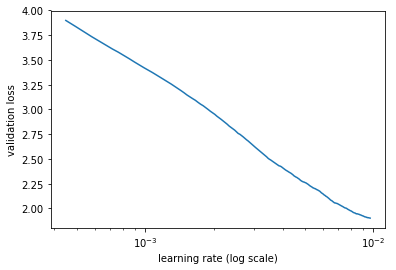

In [59]:
learner.sched.plot()

In [60]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                   
    0      2.261485   1.941066   0.487224  
    1      1.835142   1.676291   0.549044                   
    2      1.659123   1.596648   0.573428                   
    3      1.562725   1.544797   0.588478                   
    4      1.490784   1.520057   0.595382                   
    5      1.434435   1.482303   0.603465                   
    6      1.385146   1.488977   0.607564                   
    7      1.322728   1.482179   0.609835                   
    8      1.30446    1.463377   0.614599                   
    9      1.259617   1.480279   0.614497                   
    10     1.222905   1.472852   0.617364                   
    11     1.182031   1.480907   0.617951                   
    12     1.169471   1.47835    0.618324                   
    13     1.163786   1.484538   0.618227                   
    14     1.141474   1.487882   0.619499                   



[array([1.48788]), 0.6194992810487747]

In [61]:
learner.save('lm1')

In [62]:
learner.save_encoder('lm1_enc')

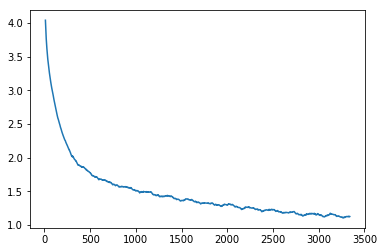

In [63]:
learner.sched.plot_loss()